In [1]:
# !pip install numpy==1.24.4 \
#             torch==2.2.2 \
#             torchvision==0.17.2 \
#             scikit-learn==1.3.2 \
#             tensorflow==2.15.0 \
#             matplotlib==3.7.3

# Python ≥3.10 is required
import sys
assert sys.version_info >= (3, 10)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

from h5py import File as HDF5Fileimport
import torch.optim as optim
from torch.nn.utils import spectral_norm
from torchvision import models
from scipy.linalg import sqrtm


np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())
print(device)

2025-06-17 15:57:51.176879: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-17 15:57:51.218919: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-17 15:57:51.218964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-17 15:57:51.220176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 15:57:51.227651: I tensorflow/core/platform/cpu_feature_guar

True
cuda


In [2]:
# Load data from npz file
with np.load('../data/QIS_EXAM_200Events.npz', allow_pickle=True) as data:
    # Extract training and test inputs from dictionary objects in the npz file
    x_train = data["training_input"].item()
    x_test = data["test_input"].item()

In [3]:
print(data.files)
print("Type of x_train:", type(x_train))
print("Keys in x_train:", x_train.keys())

['training_input', 'test_input']
Type of x_train: <class 'dict'>
Keys in x_train: dict_keys(['0', '1'])


In [4]:
# Split the training and test inputs by class
x_train_0 = x_train['0']
x_train_1 = x_train['1']
x_test_0 = x_test['0']
x_test_1 = x_test['1']

# Concatenate the training and test inputs
x_train = np.concatenate((x_train_0, x_train_1), axis=0)
x_test = np.concatenate((x_test_0, x_test_1), axis=0)

# Create corresponding binary labels for the training and test inputs
y_train = np.zeros((len(x_train),))
y_train[len(x_train_0):] = 1
y_test = np.zeros((len(x_test),))
y_test[len(x_test_0):] = 1

# the shapes of the inputs and labels
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(y_train.shape, y_test.shape)

(100, 5) (100,)
(100, 5) (100,)
(100,) (100,)


In [5]:
print(x_train_0[0])
print(y_train[0])
print(y_train[-1])


[-0.43079088  0.86834819 -0.92614721 -0.92662029 -0.56900862]
0.0
1.0


In [48]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 25),
            nn.BatchNorm1d(25),
            nn.SELU(),
            nn.Linear(25, 50),
            nn.BatchNorm1d(50),
            nn.SELU(),
            nn.Linear(50, 25),
            nn.BatchNorm1d(25),
            nn.SELU(),
            nn.Linear(25, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        self.model =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 50),
            nn.BatchNorm1d(50),
            nn.SELU(),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [49]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan
    generator.to(device)
    discriminator.to(device)
    optimizer_gen = torch.optim.Adam(generator.parameters())
    optimizer_disc = torch.optim.Adam(discriminator.parameters())
    loss_fn = nn.BCELoss()

    disc_losses = []
    gen_losses = []

    for epoch in range(n_epochs):
        epoch_disc_loss = 0
        epoch_gen_loss = 0
        batches = 0
        for X_batch, y_batch in dataset:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            batches += 1

            # Phase 1 - training the discriminator
            noise = torch.randn(batch_size, codings_size, device=device)
            gen_codings = torch.randint(0, 2, (batch_size, 1), device=device)
            
            generated_images = generator(torch.cat([noise, gen_codings], dim=1))

            X_fake_and_real = torch.cat([generated_images.squeeze(1), X_batch], dim=0)
            all_codings = torch.cat([gen_codings, y_batch.unsqueeze(1)], dim=0)
            X_fake_and_real_and_codings = torch.cat([X_fake_and_real, all_codings], dim=1)
            y1 = torch.tensor([[0.]] * batch_size + [[1.]] * batch_size, device=device)

            discriminator.zero_grad()
            predictions = discriminator(X_fake_and_real_and_codings)
            loss_d = loss_fn(predictions, y1)
            loss_d.backward()
            optimizer_disc.step()
            epoch_disc_loss += loss_d.item()

            # Phase 2 - training the generator
            noise = torch.randn(batch_size, codings_size, device=device)
            gen_codings = torch.randint(0, 2, (batch_size, 1), device=device)
            gen_images = generator(torch.cat([noise, gen_codings], dim=1))

            y2 = torch.tensor([[1.]] * batch_size, device=device)

            generator.zero_grad()
            disc_pred = discriminator(torch.cat([gen_images, gen_codings], dim=1))
            loss_g = loss_fn(disc_pred, y2)
            loss_g.backward()
            optimizer_gen.step()
            epoch_gen_loss += loss_g.item()

        disc_losses.append(epoch_disc_loss / batches)
        gen_losses.append(epoch_gen_loss / (batches * 4))

        if (epoch+1) % 100 == 0 or epoch ==0:
          print(f"Epoch {epoch+1}/{n_epochs}: DiscLoss= {loss_d:.3e}, GenLoss= {loss_g:.3e}")

    # === Plot loss curves ===
    plt.figure(figsize=(10, 5))
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.plot(gen_losses, label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GAN Training Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Epoch 1/2000: DiscLoss= 4.776e-01, GenLoss= 7.080e-01
Epoch 100/2000: DiscLoss= 5.643e-04, GenLoss= 3.022e-01
Epoch 200/2000: DiscLoss= 3.625e-04, GenLoss= 2.633e-01
Epoch 300/2000: DiscLoss= 1.124e-04, GenLoss= 2.505e-01
Epoch 400/2000: DiscLoss= 2.288e-05, GenLoss= 2.277e-01
Epoch 500/2000: DiscLoss= 1.359e-05, GenLoss= 2.116e-01
Epoch 600/2000: DiscLoss= 6.161e-06, GenLoss= 2.131e-01
Epoch 700/2000: DiscLoss= 3.405e-06, GenLoss= 1.937e-01
Epoch 800/2000: DiscLoss= 2.339e-06, GenLoss= 1.698e-01
Epoch 900/2000: DiscLoss= 1.501e-06, GenLoss= 1.547e-01
Epoch 1000/2000: DiscLoss= 1.117e-06, GenLoss= 1.536e-01
Epoch 1100/2000: DiscLoss= 1.481e-06, GenLoss= 1.452e-01
Epoch 1200/2000: DiscLoss= 2.620e-07, GenLoss= 1.297e-01
Epoch 1300/2000: DiscLoss= 2.478e-07, GenLoss= 1.411e-01
Epoch 1400/2000: DiscLoss= 1.782e-07, GenLoss= 1.070e-01
Epoch 1500/2000: DiscLoss= 7.883e-08, GenLoss= 1.386e-01
Epoch 1600/2000: DiscLoss= 9.202e-08, GenLoss= 1.302e-01
Epoch 1700/2000: DiscLoss= 2.258e-08, GenLo

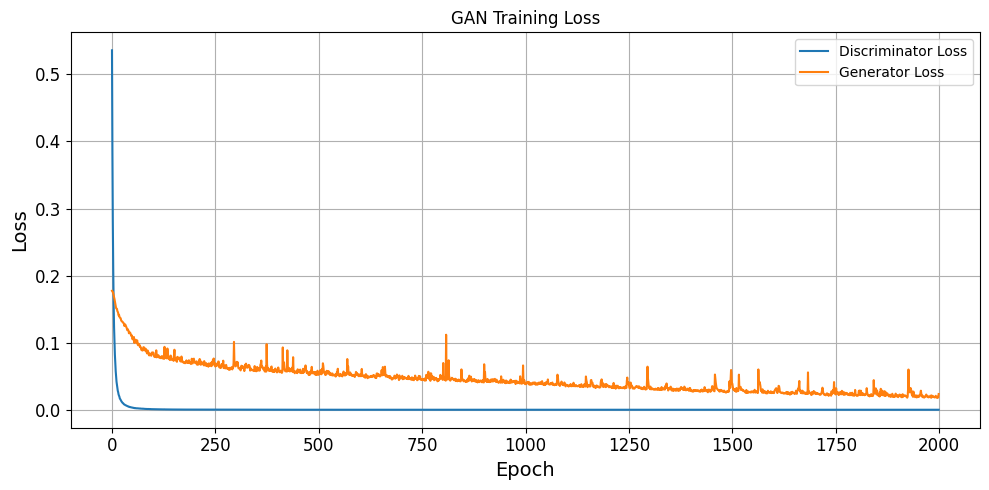

In [50]:
feature_dim= 5
batch_size = 10
latent_dim = feature_dim + 1
codings_size = feature_dim

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

generator = Generator(latent_dim, output_dim=feature_dim)
discriminator = Discriminator(input_dim=latent_dim)
gan = [generator, discriminator]

train_gan(gan, train_loader, batch_size, codings_size, n_epochs=2000)

In [ ]:
# Next: Check test data, plot data, plot metrics, test outputs of disc, gen, try reversing input to disc to see if discriminator can classify
# Change data type and size

In [2]:
!pip3 install pandas

ERROR: Could not find a version that satisfies the requirement pandas (from versions: none)
ERROR: No matching distribution found for pandas


In [1]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

import numpy as np
np.random.seed(42)  # for reproducibility
import h5py

from sklearn.metrics import roc_curve, auc

from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

import warnings

ModuleNotFoundError: No module named 'pandas'

In [ ]:
data=pd.read_csv('./HIGGS.csv', header=None)
## print the first 5 rows
data.head()

In [ ]:
## change the column numbers to column names
data.columns = ['target',
              'lep_pT',
              'lep_eta',
              'lep_phi',
              'missE',
              'missphi',
              'jet1_pt',
              'jet1_eta',
              'jet_1_phi',
              'jet_1_b_tag',
              'jet_2_pt',
              'jet_2_eta',
              'jet_2_phi',
              'jet_2_b_tag',
              'jet_3_pt',
              'jet_3_eta',
              'jet_3_phi',
              'jet_3_b_tag',
              'jet_4_pt',
              'jet_4_eta',
              'jet_4_phi',
              'jet_4_b_tag',
              'm_jj',
              'm_jjj',
              'm_lv',
              'm_jlv',
              'm_bb',
              'm_wbb',
              'm_wwbb']

## print the first 5 rows (including the column names)
data.head()

In [ ]:
X=data.iloc[:100000,1:]#data.iloc[:,1:]
y=data.iloc[:100000,0]#data.iloc[:,0]

X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)

In [ ]:
X_np = X.values
y_np = y.values.reshape(-1, 1)

X_torch = torch.tensor(X_np, dtype=torch.float32)
y_torch = torch.tensor(y_np, dtype=torch.float32)

dataset = TensorDataset(X_torch, y_torch)
val_size   = int(0.2 * len(dataset))
train_set, val_set = torch.utils.data.random_split(
    dataset, [len(dataset)-val_size, val_size]
)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=64)

In [ ]:
feature_dim= x_shape.
batch_size = 10
latent_dim = feature_dim + 1
codings_size = feature_dim

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

generator = Generator(latent_dim, output_dim=feature_dim)
discriminator = Discriminator(input_dim=latent_dim)
gan = [generator, discriminator]

train_gan(gan, train_loader, batch_size, codings_size, n_epochs=2000)

In [9]:
# Below is the classical GAN implemented by Adithya Penagonda
#!wget https://data.mendeley.com/public-files/datasets/4r4v785rgx/files/132306f6-26f4-4583-8f1b-ccc5ad8da05d/file_downloaded

In [10]:
from h5py import File as HDF5File
def load_data(filepath):
    jet_mass_data = HDF5File(filepath, 'r')
    X_jet = jet_mass_data['image']
    X_jet = np.array(X_jet)
    X_jet = torch.tensor(X_jet, dtype=torch.float32)

    # Normalize the data
    X_jet = (X_jet - X_jet.min()) / (X_jet.max() - X_jet.min())

    X_jet = X_jet.unsqueeze(1)
    X_jet_resized = nn.functional.interpolate(X_jet, size=(16, 16), mode='bilinear', align_corners=False)
    return X_jet_resized

def get_dataloader(data, batch_size=128):
    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

if __name__ == "__main__":
    jet_images_path = 'file_downloaded'
    data = load_data(jet_images_path)
    dataloader = get_dataloader(data)

/home/users.cms.physics.ua.edu/webbj/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/users.cms.physics.ua.edu/webbj/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/users.cms.physics.ua.edu/webbj/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalen

Epoch [0/30] D loss: -2.244370222091675 G loss: 4.319393157958984 FID: 505.7091315867232


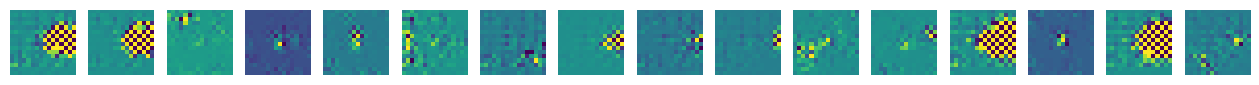

Epoch [1/30] D loss: -0.027009855955839157 G loss: 0.6492480635643005 FID: 100.49857059703365


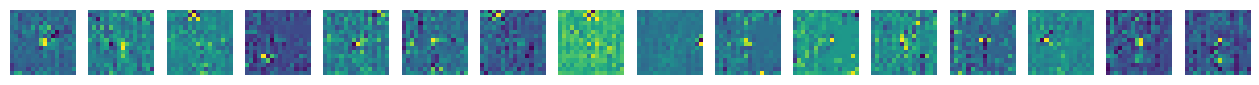

Epoch [2/30] D loss: 0.013809889554977417 G loss: 0.13605397939682007 FID: 56.04589592284354


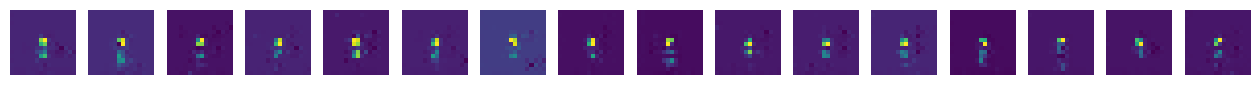

Epoch [3/30] D loss: 0.011326391249895096 G loss: 0.13040763139724731 FID: 52.3205997135428


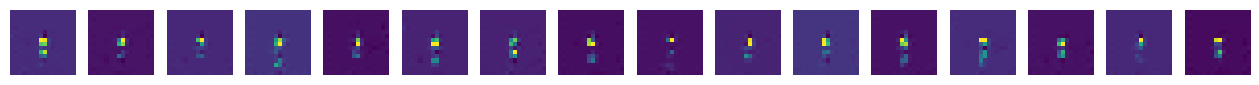

Epoch [4/30] D loss: 0.015242254361510277 G loss: 0.10803288221359253 FID: 62.788848205637215


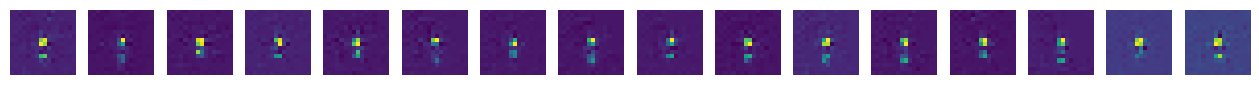

Epoch [5/30] D loss: 0.0110658323392272 G loss: 0.12005200982093811 FID: 59.5794002168023


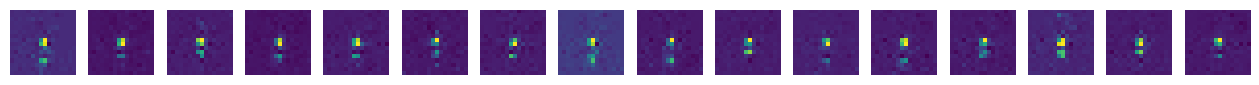

Epoch [6/30] D loss: 0.010141665115952492 G loss: 0.15711894631385803 FID: 59.294892465604875


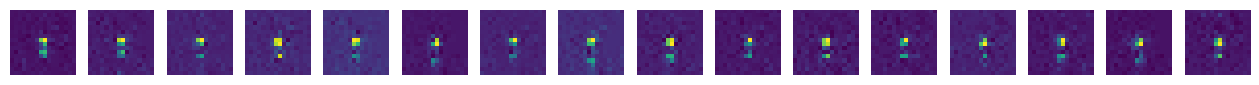

Epoch [7/30] D loss: 0.01813971996307373 G loss: 0.14994996786117554 FID: 51.89902011814974


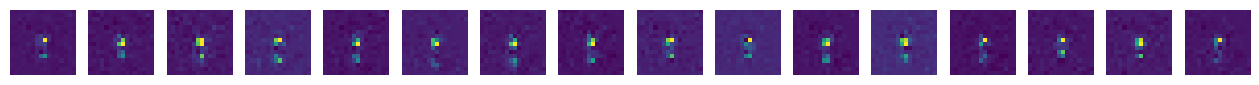

Epoch [8/30] D loss: 0.020428676158189774 G loss: 0.12530185282230377 FID: 68.11786655376511


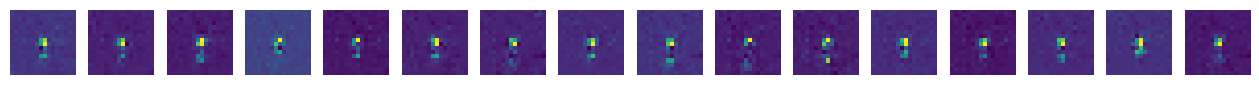

Epoch [9/30] D loss: 0.010065976530313492 G loss: 0.14431338012218475 FID: 51.76672146595163


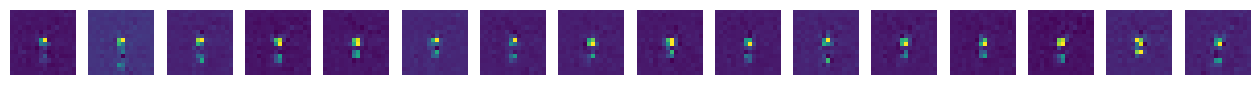

Epoch [10/30] D loss: 0.010638742707669735 G loss: 0.13990560173988342 FID: 39.85259975823646


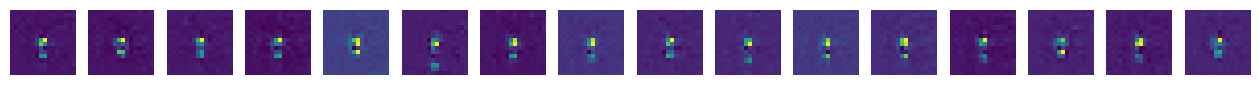

Epoch [11/30] D loss: 0.018172474578022957 G loss: 0.13443498313426971 FID: 63.02292136990785


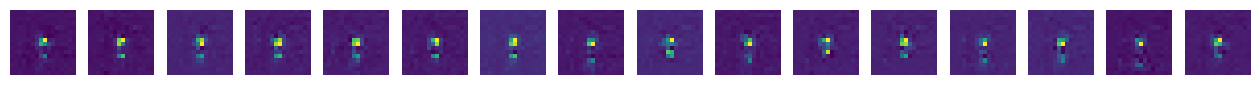

Epoch [12/30] D loss: 0.020100964233279228 G loss: 0.13081419467926025 FID: 45.53124641442654


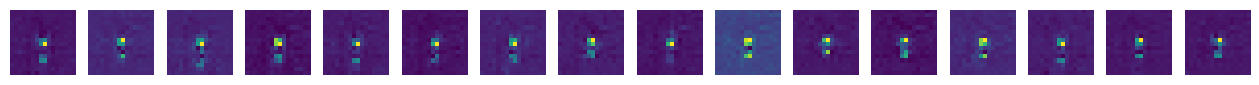

Epoch [13/30] D loss: 0.013870453462004662 G loss: 0.13017231225967407 FID: 55.2994284913555


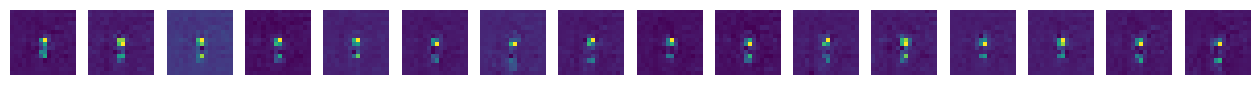

Epoch [14/30] D loss: 0.014866437762975693 G loss: 0.1376253068447113 FID: 45.0571900456527


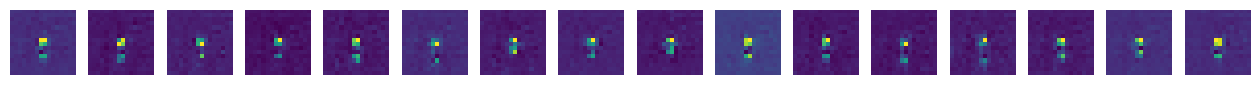

Epoch [15/30] D loss: 0.009714880958199501 G loss: 0.13601824641227722 FID: 55.18953816290684


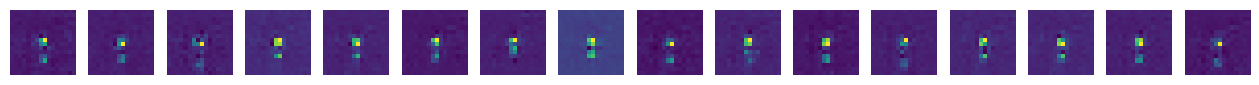

Epoch [16/30] D loss: 0.008625497110188007 G loss: 0.15617546439170837 FID: 59.25023936673493


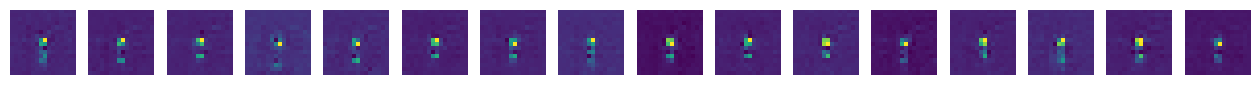

Epoch [17/30] D loss: 0.00898283813148737 G loss: 0.11829089373350143 FID: 46.35442575377802


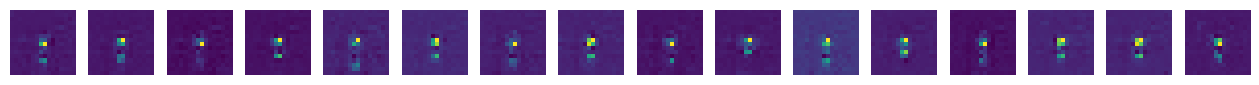

Epoch [18/30] D loss: 0.01102343387901783 G loss: 0.1121767982840538 FID: 75.51224841833064


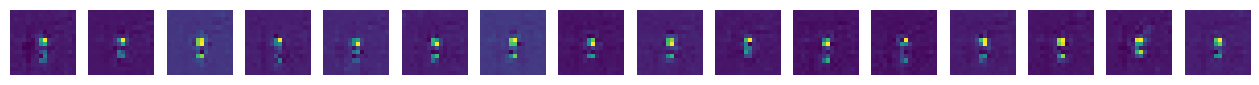

Epoch [19/30] D loss: 0.009093853645026684 G loss: 0.11948251724243164 FID: 49.58911814777119


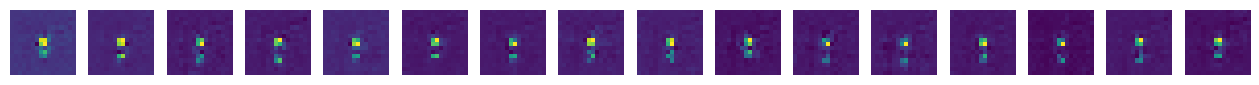

Epoch [20/30] D loss: 0.013107199221849442 G loss: 0.14300234615802765 FID: 48.41064802421872


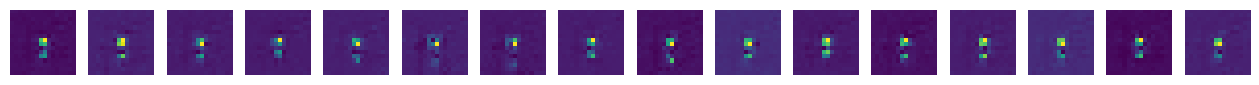

Epoch [21/30] D loss: 0.00796678476035595 G loss: 0.13226626813411713 FID: 41.07259430575355


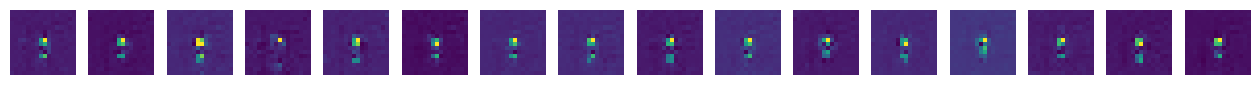

Epoch [22/30] D loss: 0.00679297000169754 G loss: 0.13411419093608856 FID: 51.78543203678031


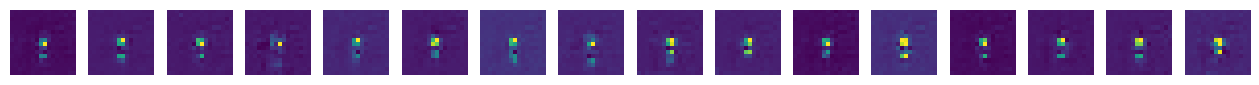

Epoch [23/30] D loss: 0.007836747914552689 G loss: 0.1331738382577896 FID: 49.9343031552272


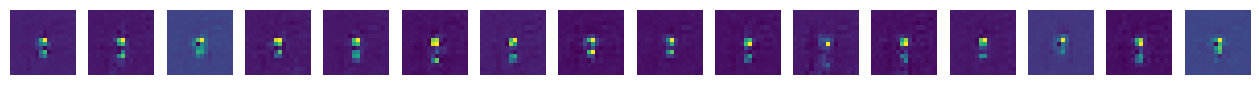

Epoch [24/30] D loss: 0.007095104083418846 G loss: 0.12849265336990356 FID: 56.56526475781176


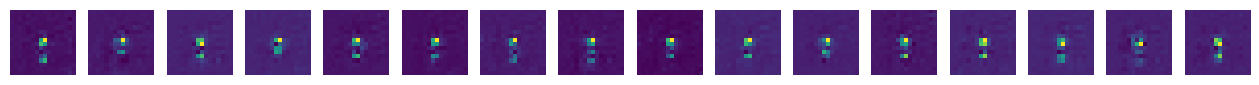

Epoch [25/30] D loss: 0.006237940862774849 G loss: 0.12877091765403748 FID: 37.04691030109762


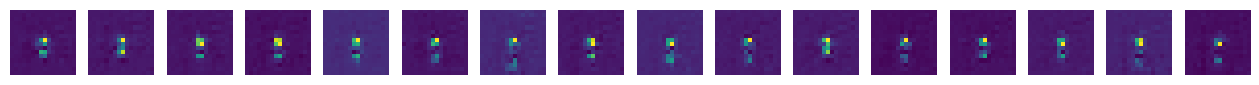

Epoch [26/30] D loss: 0.006577721796929836 G loss: 0.1347828358411789 FID: 49.09491085663989


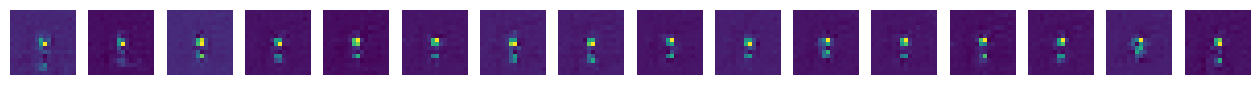

Epoch [27/30] D loss: 0.005353626795113087 G loss: 0.12697678804397583 FID: 42.02697997416584


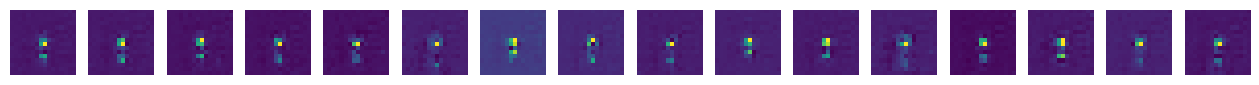

Epoch [28/30] D loss: 0.003366297110915184 G loss: 0.10835372656583786 FID: 54.10438628029978


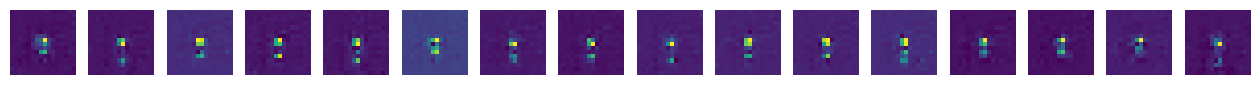

Epoch [29/30] D loss: 0.003959020599722862 G loss: 0.13201060891151428 FID: 42.31876618091457


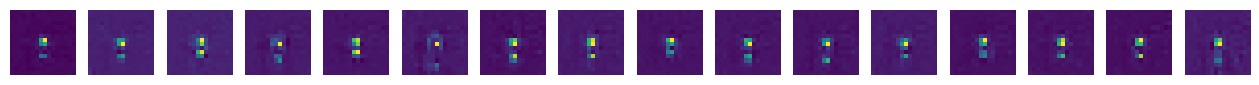

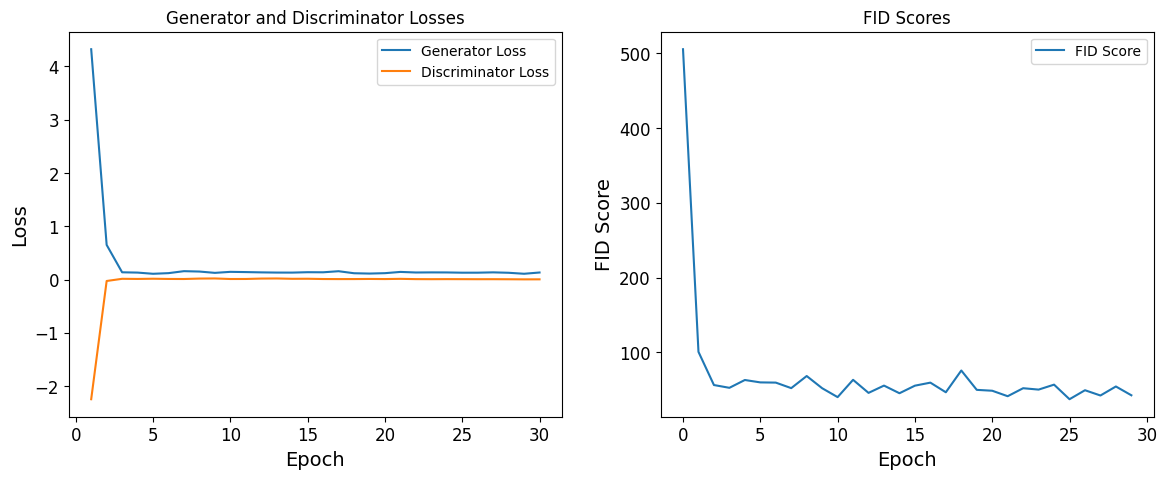

In [11]:
class PLGenerator(nn.Module):
    def __init__(self, latent_dim):
        super(PLGenerator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class PLDiscriminator(nn.Module):
    def __init__(self):
        super(PLDiscriminator, self).__init__()

        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Flatten(),
            spectral_norm(nn.Linear(128*4*4, 1, bias=False))
        )

    def forward(self, x):
        return self.model(x)

def gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates)
    fake = torch.ones(d_interpolates.size(), device=real_samples.device, requires_grad=False)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def perceptual_loss(real, fake, vgg):
    real_features = vgg(real.repeat(1, 3, 1, 1))  # Repeat channels to match VGG input
    fake_features = vgg(fake.repeat(1, 3, 1, 1))
    loss = F.mse_loss(fake_features, real_features)
    return loss

def calculate_fid(real_images, fake_images, batch_size=128):
    inception_model = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    def get_features(images):
        features = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].to(device)
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            batch = batch.repeat(1, 3, 1, 1)
            with torch.no_grad():
                pred = inception_model(batch)
            features.append(pred.cpu().numpy())
        return np.concatenate(features, axis=0)

    real_features = get_features(real_images)
    fake_features = get_features(fake_images)

    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    if sigma1.ndim == 0:
        sigma1 = np.array([[sigma1]])
    if sigma2.ndim == 0:
        sigma2 = np.array([[sigma2]])

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

latent_dim = 100
lr = 0.0002
n_epochs = 30
lambda_gp = 10
lambda_perceptual = 1  # Weight for the perceptual loss term

generator = PLGenerator(latent_dim).to(device)
discriminator = PLDiscriminator().to(device)
vgg = models.vgg16(pretrained=True).features[:16].to(device).eval()
for param in vgg.parameters():
    param.requires_grad = False

optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)

g_losses = []
d_losses = []
fid_scores = []

def plot_generated_samples(generator, latent_dim, num_samples=16):
    z = torch.randn(num_samples, latent_dim, 1, 1).to(device)
    gen_samples = generator(z).detach().cpu()
    gen_samples = (gen_samples + 1) / 2.0

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 1))
    for i in range(num_samples):
        axes[i].imshow(gen_samples[i, 0])
        axes[i].axis('off')
    plt.show()

def plot_metrics(g_losses, d_losses, fid_scores):
    epochs = range(1, len(g_losses) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, g_losses, label='Generator Loss')
    plt.plot(epochs, d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator and Discriminator Losses')

    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(fid_scores)), fid_scores, label='FID Score')
    plt.xlabel('Epoch')
    plt.ylabel('FID Score')
    plt.legend()
    plt.title('FID Scores')

    plt.show()

for epoch in range(n_epochs):
    for i, (real_samples,) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        batch_size = real_samples.size(0)

        optimizer_D.zero_grad()

        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_samples = generator(z).detach()
        real_validity = discriminator(real_samples)
        fake_validity = discriminator(fake_samples)

        gp = gradient_penalty(discriminator, real_samples, fake_samples)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

        d_loss.backward()
        optimizer_D.step()

        if i % 5 == 0:
            optimizer_G.zero_grad()

            z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
            gen_samples = generator(z)
            gen_validity = discriminator(gen_samples)

            perceptual_loss_value = perceptual_loss(real_samples, gen_samples, vgg)
            g_loss = -torch.mean(gen_validity) + lambda_perceptual * perceptual_loss_value

            g_loss.backward()
            optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    z = torch.randn(1000, latent_dim, 1, 1).to(device)
    fake_images = generator(z).detach().cpu()
    real_images = next(iter(dataloader))[0][:1000].cpu()

    fid = calculate_fid(real_images, fake_images, batch_size=batch_size)
    fid_scores.append(fid)
    print(f"Epoch [{epoch}/{n_epochs}] D loss: {d_loss.item()} G loss: {g_loss.item()} FID: {fid}")

    output_image = fake_images[:16]  # Save 16 generated samples
    output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    grid = torchvision.utils.make_grid(output_image, nrow=4)
    np_img = grid.numpy().transpose((1, 2, 0))
    #plt.imsave(f'classical_Jet_image_PL_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator, latent_dim)

plot_metrics(g_losses, d_losses, fid_scores)

In [12]:
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA A100-PCIE-40GB
